In [51]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np

In [85]:
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid)
        self.dense3 = tf.keras.layers.Dense(10, activation=tf.nn.softmax)
        
    @tf.function
    def call(self, inputs):
        print(inputs)
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x
        
class SimpleDense(tf.keras.layers.Layer):
    
    def __init__(self, units=256):
        super(SimpleDense, self).__init__()
        self.units = units
        self.acitvation = tf.nn.softmax
        
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)
        
    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x


In [98]:
import tensorflow_datasets as tfds
train_ds, test_ds = tfds.load('genomics_ood', split=['train', 'test'], as_supervised=True)

def onehotify(seq, label):
    vocab = {"A":"1", "C":"2", "G":"3", "T":"0"}
    for key in vocab.keys():
        seq = tf.strings.regex_replace(seq, key, vocab[key]) 
    split = tf.strings.bytes_split(seq)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8) 
    onehot = tf.one_hot(labels, 4)
    seq = tf.reshape(onehot, (-1,))
    label = tf.cast(label, tf.uint8)
    label = tf.one_hot(label, depth=10)
    
    return seq, label

def preprocess_data(dataset):
    dataset = dataset.map(onehotify, num_parallel_calls=4)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(20)
    return dataset


train_ds = train_ds.apply(preprocess_data)
test_ds = test_ds.apply(preprocess_data)

for element in train_ds.take(1):
    seq, label = element
    print(seq,"label: ", label)
    


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
tf.Tensor(
[[1. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]], shape=(32, 1000), dtype=float32) label:  tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0

In [99]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function):
    
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))
        
    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)
    
    return test_loss, test_accuracy




In [100]:
tf.keras.backend.clear_session()
train_dataset = train_ds.take(1000)
test_dataset = test_ds.take(100)

num_epochs = 10
learning_rate = 0.1

model = MyModel()

cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.SGD(learning_rate)

train_losses = []
test_losses = []
test_accuracies = []

test_loss, test_accuracy = test(model, train_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    


Tensor("inputs:0", shape=(32, 1000), dtype=float32)
Tensor("inputs:0", shape=(32, 1000), dtype=float32)
Epoch: 0 starting with accuracy 0.08553125
Epoch: 1 starting with accuracy 0.3278125
Epoch: 2 starting with accuracy 0.3475
Epoch: 3 starting with accuracy 0.348125
Epoch: 4 starting with accuracy 0.3596875
Epoch: 5 starting with accuracy 0.3384375
Epoch: 6 starting with accuracy 0.3409375
Epoch: 7 starting with accuracy 0.3425
Epoch: 8 starting with accuracy 0.3453125
Epoch: 9 starting with accuracy 0.3603125


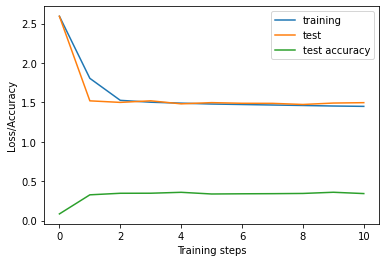

In [101]:
import matplotlib.pyplot as plt

# Visualize accuracy and loss for training and test data.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()